<a href="https://colab.research.google.com/github/flora-p/BSD-QBio8/blob/main/Northwestern_NMF_workshop_Part_1_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2023 Quantitative Biology Workshop Part 1: Dimension reduction with NMF**

_"As simple as possible, but no simpler"_

Zach DeBrune, PhD and Tim Triche, Jr., PhD

Today we want to share with you some tools that we find useful when trying to understand how millions of cells work together to develop into multicellular organisms. Sometimes, the same models also help us understand how that can fail. One tool that strikes a nice balance between power and understandable output is called NMF, or non-negative matrix factorization. We use it a lot, on millions of cells, but also in collections of rare disease samples and population-scale genetic databases. We feel that it helps us keep things "_as simple as possible, but no simpler_". Biology is complicated enough!

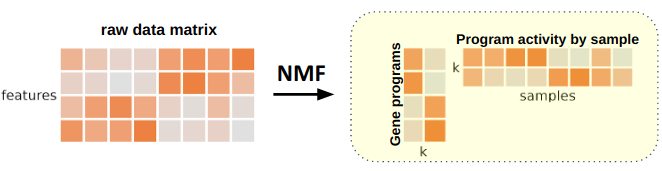

**After this workshop, we want you to feel comfortable with:**

* dimension reduction, denoising, and annotation of gene programs with NMF (Part 1)
* accessing sources of well-annotated single cell data, such as CELLxGENE (segue to Part 2)
* how to fit new models and re-use existing models to explore new data (Part 2)


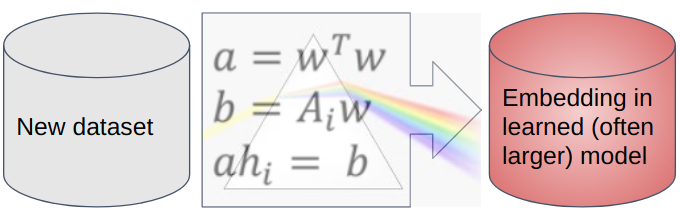


We are using Google Colab so you can share and hopefully build upon your work today. 

We'd love to see what you build with these tools in your own research!

#**Install necessary packages**

We need some packages for the code exercises in this workshop. 

Let's make sure we are running a reasonable operating system:

In [ ]:
system("cat /etc/issue", intern=TRUE)

[1] "Ubuntu 20.04.5 LTS \\n \\l" ""

OK, that's fine. Let's install some necessary packages. `tidyverse` in particular needs some system libraries installed with `sudo`.


In [ ]:
system("sudo apt update")
system("sudo apt install python3-apt python3-dbus python3-gi libharfbuzz-dev libfribidi-dev r-cran-tidyverse r-cran-devtools r-cran-bspm r-cran-remotes r-cran-biocmanager")
if (suppressPackageStartupMessages(require("tidyverse"))) message("Verified that `tidyverse` is installed.")

Verified that `tidyverse` is installed.




We also try and install every binary package we can to avoid later delays from `Seurat` and `singlet` installation.

(It's a good idea to start this code running long before you need it!)

In [ ]:
system("sudo apt update")
system("sudo apt install r-cran-hexbin r-cran-abind r-cran-bh r-cran-viridis r-cran-bitops r-cran-catools r-cran-cowplot r-cran-crosstalk r-cran-deldir r-cran-dqrng r-cran-fitdistrplus r-cran-fnn r-cran-future r-cran-future.apply r-cran-ggrepel r-cran-ggridges r-cran-globals r-cran-goftest r-cran-gplots r-cran-gridextra r-cran-gtools r-cran-here r-cran-htmlwidgets r-cran-httpuv r-cran-ica r-cran-igraph r-cran-irlba r-cran-later r-cran-lazyeval r-cran-leiden r-cran-listenv r-cran-lmtest r-cran-matrixstats r-cran-miniui r-cran-parallelly r-cran-patchwork r-cran-pbapply r-cran-plotly r-cran-plyr r-cran-png r-cran-polyclip r-cran-progressr r-cran-promises r-cran-rann r-cran-rcpp r-cran-rcppannoy r-cran-rcpparmadillo r-cran-rcppeigen r-cran-rcppgsl r-cran-rcppprogress r-cran-rcpptoml r-cran-reshape2 r-cran-reticulate r-cran-rocr r-cran-rtsne r-cran-scattermore r-cran-sctransform r-cran-seuratobject r-cran-shiny r-cran-shinyace r-cran-shinyjs r-cran-shinywidgets r-cran-sitmo r-cran-sourcetools r-cran-sp r-cran-spatstat.data r-cran-spatstat.explore r-cran-spatstat.geom r-cran-spatstat.random r-cran-spatstat.sparse r-cran-spatstat.utils r-cran-tensor r-cran-uwot r-cran-xtable r-cran-zoo")
if (suppressPackageStartupMessages(require("SeuratObject"))) message("Verified that `SeuratObject` is installed.")

Verified that `SeuratObject` is installed.



`Seurat` can take a while to install, since it depends on every package ever written and then a couple others.

In [ ]:
BiocManager::install("Seurat", update=FALSE, quiet=TRUE, ask=FALSE)
if (suppressPackageStartupMessages(require("Seurat"))) message("Verified that `Seurat` is installed and loaded.")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Seurat'”
Verified that `Seurat` is installed and loaded.



The version of `RcppML` on GitHub is more recent than that on CRAN, so we'll use it for NMF-related calculations and manipulations.

In [ ]:
suppressMessages(suppressWarnings(BiocManager::install(c("scuttle", "fgsea", "limma"), quiet=TRUE)))
if (require("limma", quietly=TRUE)) message("Finished updating prerequisites.")
suppressMessages(BiocManager::install("zdebruine/RcppML", quiet=TRUE))
if (require("RcppML", quietly=TRUE)) message("Finished updating RcppML from GitHub.")

Finished updating prerequisites.

Finished updating RcppML from GitHub.



Let's install `singlet` from GitHub, since that's currently where it lives.

In [ ]:
suppressWarnings(suppressMessages(BiocManager::install("zdebruine/singlet", force=TRUE, update=TRUE)))
if (require("singlet", quietly=TRUE)) message("Finished installing singlet from GitHub.")


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpCDjqyl/remotes4c4f3a99d02c/zdebruine-singlet-765a6c4/DESCRIPTION’ ... OK
* preparing ‘singlet’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘singlet/data/pbmc3k.RData’
* building ‘singlet_0.99.26.tar.gz’



Finished installing singlet from GitHub.



# A guided tour of NMF with Seurat and PBMC3K

[`Seurat`](https://satijalab.org/seurat/) ships with some excellent tutorials, a major reason for its success. Let's retrace the steps in one of them, using data from about 3000 peripheral blood mononuclear cells. 

Rather than just using the more common principal components analysis, we will also use non-negative matrix factorization (NMF) to denoise and compress the data from the cells. Some reasons why you might want to do such a thing can be found in [the FASTNMF paper](https://www.biorxiv.org/content/10.1101/2021.09.01.458620v1.full), but the short version is that we think it produces results which are usually easier to interpret than PCA. Caveat lector: use the best tool for _your_ experiment and design, whether or not that's NMF.

Output from the `singlet` example can also be found [here](https://zdebruine.github.io/singlet/articles/Guided_Clustering_with_NMF.html) if you want to check your work or just skip ahead a little bit.

In [ ]:
# need to resolve installation ASAP!
library(singlet)

Let's load the PBMC3K data for the tour.

In [ ]:
library(Seurat)
library(Matrix)
data <- get_pbmc3k_data()
data

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

OK, that's 13714 genes measured across 2700 cells (close enough).

It's wise to log-normalize (or more accurately, `log(1 + (count / total_counts))` normalize) RNA-sequencing data before applying anything that assumes linearity of residuals, so that's the first thing we do.

In [ ]:
(data <- NormalizeData(data))

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

We can look at the result grapically:

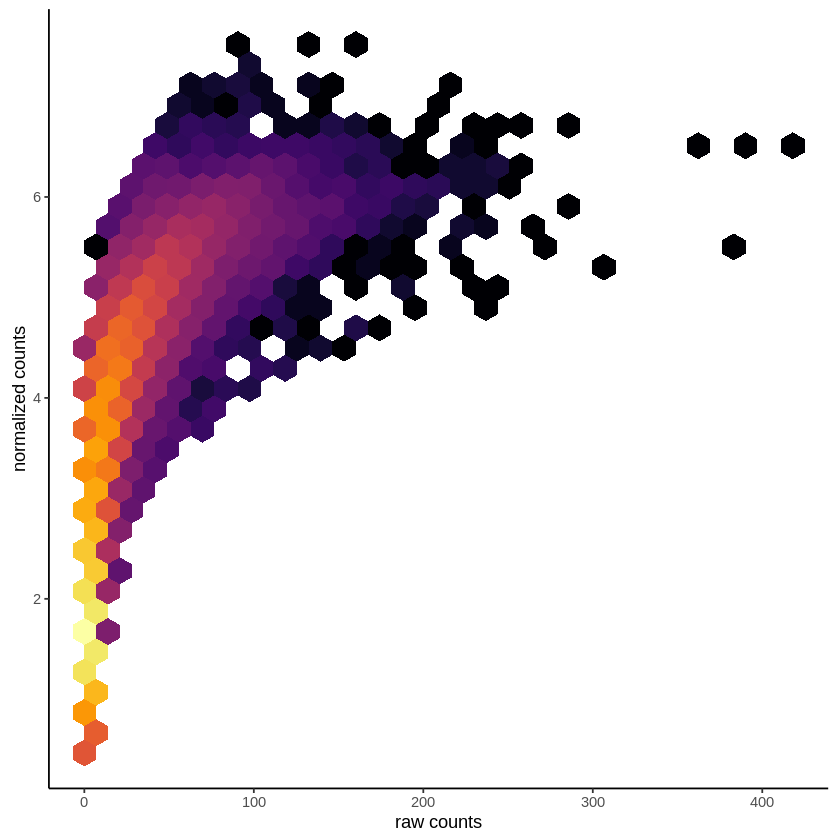

In [ ]:
library(ggplot2)
library(viridis)
ggplot(data.frame("x" = data@assays$RNA@counts@x, 
                  "y" = data@assays$RNA@data@x), 
       aes(x, y)) + 
  geom_hex() + 
  scale_fill_viridis(option = "B", trans = "log10") + 
  theme_classic() + 
  theme(aspect.ratio = 1, legend.position = "none") +
  labs(x = "raw counts", y = "normalized counts")

The critical thing to remember is that, when you use any sort of a linear decomposition (i.e. "weighted combinations of things"), it implicitly assumes that the mean and variance of your measurements are not correlated. Log-transforming the counts ensures that's roughly true.

In a typical single-cell experiment, the number of reads per cell can vary significantly. Below, we plot the number of identified features in each cell against the number of total mapped reads in that cell.

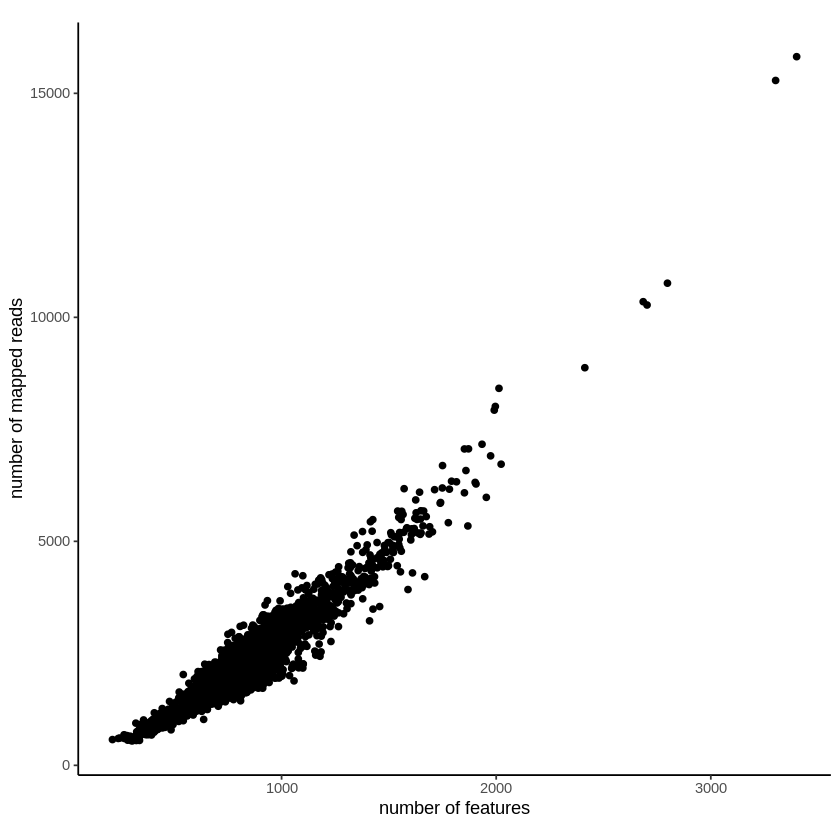

In [ ]:
ggplot(data.frame("x" = colSums(data@assays$RNA@counts != 0), 
                  "y" = colSums(data@assays$RNA@counts)), aes(x, y)) +
  geom_point() +
  theme_classic() +
  theme(aspect.ratio = 1) +
  labs(x = "number of features", y = "number of mapped reads")

# The CELLxGENE Discover tool (segue to Part 2)

While using NMF on a decade-old single-cell RNAseq dataset is expedient, that's probably not what you came here to learn about. Fortunately, the explosion of single-cell transcriptomic, multi-omic, and spatial data has provided an awful lot of opportunities for data reuse and data integration. One of the best maintained, best annotated, and easiest places to start is the database housing the Human Cell Atlas, which has been renamed [CELLxGENE](https://cellxgene.cziscience.com/) (since it now has mouse and fish atlases, too). As microscopy and spatial transcriptomics starts to merge with single-cell suspension-based transcriptome and multiome work, you can expect to see more changes in the way that CELLxGENE organizes these results. For example, we are working with the fine folks at CZI to add a large (more or less complete) NMF model of gene programs operating in development directly into the CELLxGENE database. The hope is that by providing "gene program" activity alongside single-cell activity, both known and unknown genes and expression programs can be more rapidly studied and, eventually, their role in normal and abnormal development understood. Even if you don't want to write a single line of code or search a single database, though, you can use data from [all 50 million cells in CELLxGENE](https://cellxgene.cziscience.com/gene-expression) directly from the web.  (_Activity: tour CELLxGENE expression web with MBD2/MBD3 in brain cells_) 

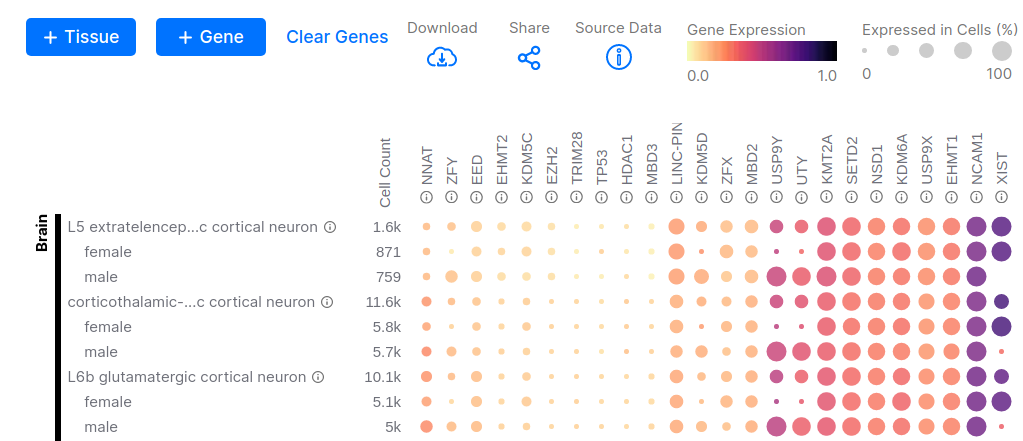